##Account name/Account ID Reconciliation

###Justin Parsons
###MSDS696 S8W2 2025

This notebook contains EDA focused on account_id and account_name. During MSDS692 it was discovered that multiple account_names are assigned to single account_ids. Multiple producers are listed under more than one name, not all of which can be accounted for by performing normal NLP treatments. For example acquisitions and company name changes appear as more than one producer if only considering account_name entries.  

Note: I found that uploading the data to the colab environment truncates the data. To remedy this I've uploaded the data to google drive and am accessing it there.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from google.colab import drive

In [2]:
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/GHG/Data/"


#create dataframe
file_name = r'Mega_merged_all_real_values.csv'

#this is here as a reminder that drive connections must be set properly for personal environment
try:
  df = pd.read_csv(path+file_name)
  print(df.sample(5)) # 5 samples from the DF
except FileNotFoundError:
  print(f"Error: File not found at {file_name}")
except Exception as e:
  print(f"An error occurred: {e}")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<ipython-input-2-b61d295c4b99>:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+file_name)


        account_id                 account_name incorporated_country  \
80848        19075  Thomson Reuters Corporation                  USA   
158803       31273                     Iren SpA                Italy   
105932       48885              Knorr-Bremse AG              Germany   
112152      847212        SpareBank 1 Østlandet               Norway   
111259       16645    SEKISUI CHEMICAL CO.,LTD.                Japan   

          ticker         Evaluation_status  \
80848     TRI CN  Not relevant, calculated   
158803       NaN  Not relevant, calculated   
105932    KBX GR      Relevant, calculated   
112152   SPOL NO      Relevant, calculated   
111259   4204 JP      Relevant, calculated   

                                   Scope_3_emissions_type  \
80848   Fuel-and-energy-related activities (not includ...   
158803                                      Capital goods   
105932                                    Business travel   
112152                      Waste generated in

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181156 entries, 0 to 181155
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    181156 non-null  int64  
 1   account_name                  181156 non-null  object 
 2   incorporated_country          181156 non-null  object 
 3   ticker                        117989 non-null  object 
 4   Evaluation_status             180307 non-null  object 
 5   Scope_3_emissions_type        181156 non-null  object 
 6   Scope_3_emissions_amount      181156 non-null  float64
 7   Symbol_1                      181156 non-null  object 
 8   Year                          181156 non-null  int64  
 9   Market_Cap                    115901 non-null  float64
 10  Employee_Count                23397 non-null   float64
 11  ebitda                        118470 non-null  float64
 12  Revenue                       118470 non-nul

Cleaning account_name prior to standardizing will reduce the amount of mis-matches. Capitalization was left for ease of reading accoun_names.

In [4]:
#cleans account_name

def remove_whitespace_punctuation(account_name):
  if account_name is None:
    return None
  account_name = re.sub(r'\s+', '', account_name)  #remove whitespace
  account_name = re.sub(r'[^\w\s]', '', account_name)  #remove punctuation
  return account_name


In [5]:
df['account_name'] = df['account_name'].apply(remove_whitespace_punctuation)

In [6]:
#displaying unique ID and account names.
try:
  unique_account_id_count = df['account_id'].nunique()
  unique_account_name_count = df['account_name'].nunique()

  print(f"Number of unique account IDs: {unique_account_id_count}")
  print(f"Number of unique account names: {unique_account_name_count}")

except Exception as e:
  print(f"An error occurred: {e}")


Number of unique account IDs: 8795
Number of unique account names: 9319


I've decided to standardize account_name, ticker, and Symbol_1 to the most recently reported values for each account_id.

In [7]:
#group by account_id and get the most recent year for each group
df['Year'] = pd.to_datetime(df['Year'], errors='coerce').dt.year
df_recent = df.loc[df.groupby('account_id')['Year'].idxmax()]

#dictionary mapping account_id to the most recent account_name, ticker, and Symbol_1
mapping_dict = df_recent.set_index('account_id')[['account_name', 'ticker', 'Symbol_1']].to_dict('index')

#function to replace values based on account_id
def replace_values(row):
  if row['account_id'] in mapping_dict:
    row['account_name'] = mapping_dict[row['account_id']]['account_name']
    row['ticker'] = mapping_dict[row['account_id']]['ticker']
    row['Symbol_1'] = mapping_dict[row['account_id']]['Symbol_1']
  return row

df = df.apply(replace_values, axis=1)


In [10]:
try:
  unique_account_id_count = df['account_id'].nunique()
  unique_account_name_count = df['account_name'].nunique()

  print(f"Number of unique account IDs: {unique_account_id_count}")
  print(f"Number of unique account names: {unique_account_name_count}")

except Exception as e:
  print(f"An error occurred: {e}")

Number of unique account IDs: 8795
Number of unique account names: 8792


In [8]:
print(df['account_name'].sample(5))

153935              StericycleInc
110685                   SPGlobal
143492    AmorePacificCorporation
96406       WinSemiconductorsCorp
11771        PerpetualInvestments
Name: account_name, dtype: object


In [9]:
print(df['account_id'].sample(5))

29583      5351
145294     3450
164246    53746
113050    73480
35067     20523
Name: account_id, dtype: int64


In [11]:
df.to_csv('/content/drive/MyDrive/GHG/Data/MM_accounts_fix.csv', index=False)


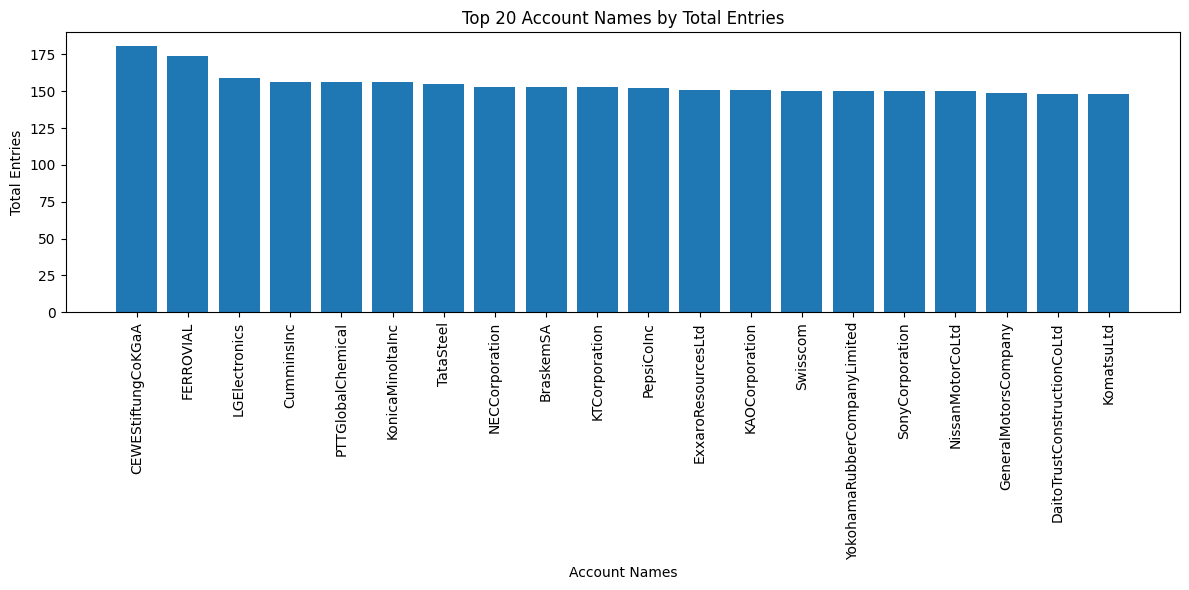

In [12]:
#plot top 20 accounts by number of entries
account_name_counts = df['account_name'].value_counts()
top_20_account_names = account_name_counts.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top_20_account_names.index, top_20_account_names.values)
plt.xlabel('Account Names')
plt.ylabel('Total Entries')
plt.title('Top 20 Account Names by Total Entries')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


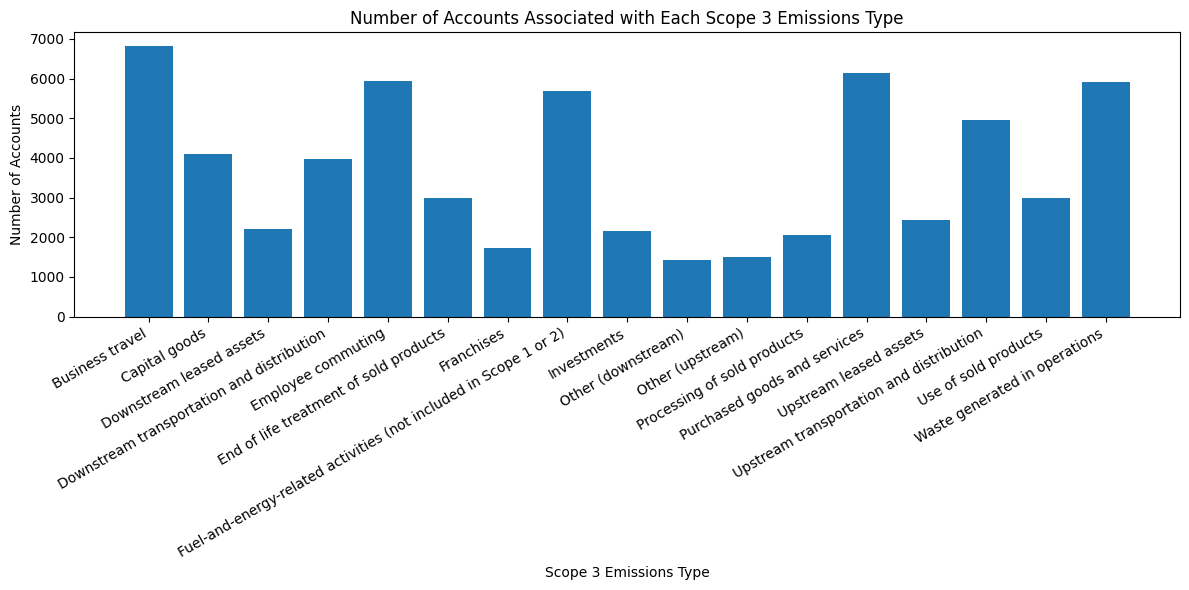

In [18]:


#group by 'Scope_3_emissions_type' and count the number of unique accounts
account_counts_by_type = df.groupby('Scope_3_emissions_type')['account_id'].nunique()

# bar plot
plt.figure(figsize=(12, 6))
plt.bar(account_counts_by_type.index, account_counts_by_type.values)
plt.xlabel('Scope 3 Emissions Type')
plt.ylabel('Number of Accounts')
plt.title('Number of Accounts Associated with Each Scope 3 Emissions Type')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [1]:
!pwd

/content
